In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
train_dir = r'C:\Users\malha\Desktop\MasterWayne\healthcare project\CNN_healthcare_model\penumonia\chest_xray\train'
val_dir = r'C:\Users\malha\Desktop\MasterWayne\healthcare project\CNN_healthcare_model\penumonia\chest_xray\val'
test_dir = r'C:\Users\malha\Desktop\MasterWayne\healthcare project\CNN_healthcare_model\penumonia\chest_xray\test'

In [3]:
train_normal = pd.DataFrame({"path": os.listdir(train_dir + "/NORMAL"), "label": "NORMAL"})
train_normal["path"] = train_normal["path"].apply(lambda x: train_dir + "/NORMAL/" + x)
train_pneumonia = pd.DataFrame({"path": os.listdir(train_dir + "/PNEUMONIA"), "label": "PNEUMONIA"})
train_pneumonia["path"] = train_pneumonia["path"].apply(lambda x: train_dir + "/PNEUMONIA/" + x)

train_df = pd.concat([train_normal, train_pneumonia])

val_normal = pd.DataFrame({"path": os.listdir(val_dir + "/NORMAL"), "label": "NORMAL"})
val_normal["path"] = val_normal["path"].apply(lambda x: val_dir + "/NORMAL/" + x)
val_pneumonia = pd.DataFrame({"path": os.listdir(val_dir + "/PNEUMONIA"), "label": "PNEUMONIA"})
val_pneumonia["path"] = val_pneumonia["path"].apply(lambda x: val_dir + "/PNEUMONIA/" + x)

val_df = pd.concat([val_normal, val_pneumonia])

In [4]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_df, 
                                        test_size = 0.2, 
                                        random_state = 42, 
                                        stratify = train_df["label"], 
                                        shuffle = True)

val_data = pd.concat([val_df, val_data])

print(f"Training set size after re-splitting training data: {len(train_data)}")
print(f"Validation set size after re-splitting training data: {len(val_data)}")

Training set size after re-splitting training data: 4172
Validation set size after re-splitting training data: 1060


In [5]:
datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rescale = 1./255
)

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_datagen =tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    x_col = "path",
    y_col = "label",
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    x_col = "path",
    y_col = "label",
    target_size = (244,224),
    class_mode = "categorical",
    batch_size =32,
    shuffle = True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False,
    seed = 42
)

Found 4172 validated image filenames belonging to 2 classes.
Found 1060 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
pretrained_model = DenseNet121(include_top = False, weights = "imagenet", input_shape = (224,224, 3))

In [10]:
pretrained_model.trainable=False

In [11]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = pretrained_model(inputs)
print(f"Shape after base_model: {x.shape}")
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(x)

model_DenseNet = tf.keras.Model(inputs, outputs)

Shape after base_model: (None, 7, 7, 1024)
After GlobalAveragePooling2D(): (None, 128)


In [12]:
model_DenseNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dense (Dense)               (None, 7, 7, 128)         131200    
                                                                 
 global_average_pooling_laye  (None, 128)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 2)                 258       
                                                                 
Total params: 7,168,962
Trainable params: 131,458
Non-trainable params: 7,037,504
_____________________________________________

In [13]:
model_DenseNet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [14]:
history_model_DenseNet = model_DenseNet.fit(train_generator,
                          epochs=4,
                          steps_per_epoch=len(train_generator),
                          validation_data=val_generator,
                          validation_steps=len(val_generator))

Epoch 1/4
131/131 [==============================] - 147s 1s/step - loss: 0.2173 - accuracy: 0.9108 - val_loss: 0.1232 - val_accuracy: 0.9575
Epoch 2/4
131/131 [==============================] - 104s 796ms/step - loss: 0.1452 - accuracy: 0.9432 - val_loss: 0.1122 - val_accuracy: 0.9547
Epoch 3/4
131/131 [==============================] - 104s 795ms/step - loss: 0.1125 - accuracy: 0.9585 - val_loss: 0.0901 - val_accuracy: 0.9660
Epoch 4/4
131/131 [==============================] - 104s 790ms/step - loss: 0.1135 - accuracy: 0.9566 - val_loss: 0.1248 - val_accuracy: 0.9491


In [15]:
# Plot the validation and training data separately
def plot_loss_curves(history):
 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

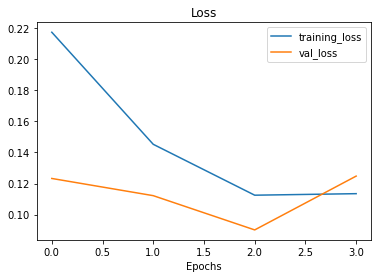

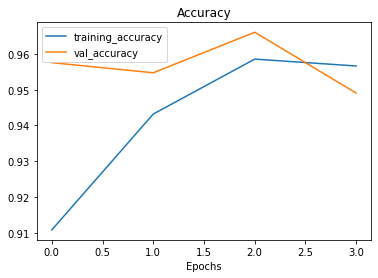

In [16]:
plot_loss_curves(history_model_DenseNet)

In [17]:
prediction = np.argmax(model_DenseNet.predict(test_generator), axis=1)
prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_generator.labels, prediction)
clr = classification_report(test_generator.labels, prediction)

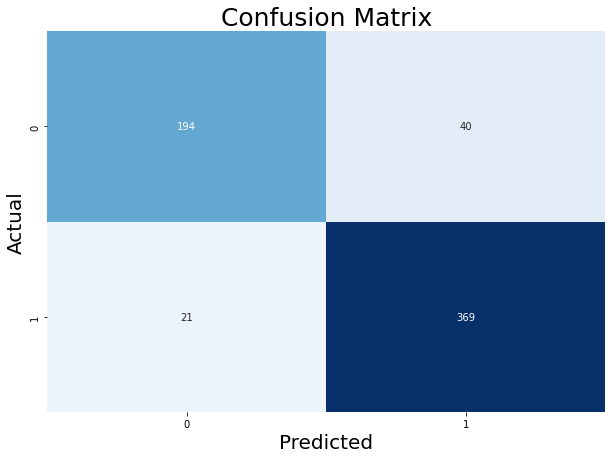

In [19]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xlabel("Predicted",fontsize=20)
plt.ylabel("Actual",fontsize=20)
plt.title("Confusion Matrix",fontsize=25)
plt.show();

In [20]:
print(clr)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       234
           1       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624

